## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

This is a final project for the “Practical Statistics” section of “Data Analyst” Nanodegree course by Udacity. Completion of this project requires understanding and application of statistical methods/skills below:

- Probability
- Standardizing 
- A/B Test
- Regression / Logistic Regression

#### About the Data ####

This project analyzes an A/B test conducted by an e-commerce company. The company developed a new web page with the hope that it would increase the sales by the visitors of the page. 

The goal of this project is to go through each analysis step and help the company decide if they should implement the new page, keep the old page, or run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" & landing_page == "old_page"').shape[0] + df.query('group == "control" & landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
query1 = df.query('group == "treatment" & landing_page == "new_page"')
query2 = df.query('group == "control" & landing_page == "old_page"')
df2 = query1.append(query2, ignore_index=True)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(1404)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.query('converted == 1').shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment" & converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:**

More considerations and examinations are needed to determine if the new treatment page leads to more conversions. My reasons are as follows:

- The data we have here is only descriptive. More tests are needed to see if there is truly a significant correlation between the variables
- Novelty effect and change aversion might play a role in users' behavior and need to be considered
- The length of the experiment time needs to be long enough to study "changes in behavior based on time of day/week or seasonal events." (Quote from the course)

<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**

$H_{0}$ $:$ $p_{new}$ $-$ $p_{old}$ $\leq$ $0$

$H_{1}$ $:$ $p_{new}$ $-$ $p_{old}$ $>$ $0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
# P_new conversion rate = overall converted rate regardless of the page
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
# P_old conversion rate = overall converted rate regardless of the page
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

-0.0001396890968886344

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new], replace=True).sum()
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old], replace=True).sum()
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

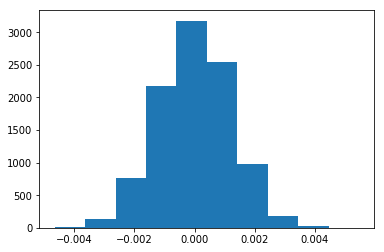

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
obs_p_new = df2.query('group == "treatment" & converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
obs_p_old = df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]

obs_p_diffs = obs_p_new - obs_p_old
obs_p_diffs

-0.0015782389853555567

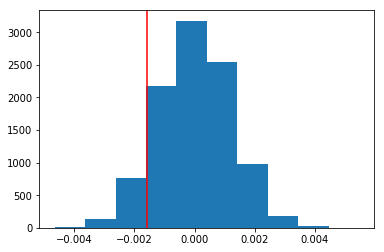

In [28]:
plt.hist(p_diffs);
plt.axvline(obs_p_diffs, color='red');

In [29]:
(p_diffs > obs_p_diffs).mean()

0.90339999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

- P-value
- P-value refers to the probability of getting statistic or a more extreme value if the null hypothesis is true. The result of ~0.9, which is large, provides the evidence that our statistic is likely to have come from the null hypothesis and fails to reject the null hypothesis, which states that the converted rate for the new page equals or is smaller than that of old page

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
'z_score: {0}, p_value: {1}'.format(z_score, p_value)

'z_score: -1.3109241984234394, p_value: 0.9050583127590245'

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**

- The z-score of -1.31 falls within the range of 95% (corresponding to value of 1.96)
- The p-value of 0.90 is much higher than the alpha value of 0.05
- There is no evidence to reject the null hypothesis, which states the conversion rate of new page equals or is smaller than that of old page
- The results are consistent with the findings in parts j. and k.

<a id='regression'></a>
## Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**

- Logistic regression would be the best option

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1

group_dummies = pd.get_dummies(df2['group'])
df2['ab_page'] = group_dummies.treatment

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
logm_results = logm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
logm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:26:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:**

- The p-value associated with ab_page is 0.19
- The p-values in Part II and Part III are of different types of hypothesis:
    - The null hypothesis in logistic regression is that there is no correlation between the dependent and independent variables, which are conversion rate and the type of page shown in our case
    - However, the null hypothesis in Part II is the conversion rate of new page equals or is smaller than that of old page
    - The difference of p-value is then due to the approach we take to analyze the data under different hypotheses

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

- Additional factors would provide us more ways to analyze the data, which might give us valuable information needed for better decisions. For example, the addition of user's country of residence to the dataset might help the company decide if localized webpage design would change users' behavior 

- However, the risk of human error might increase with the addition of factors. It might also lead to misinterpretation of the data

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df2 = df2.join(df_countries.set_index('user_id'), on='user_id')

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [39]:
countries_dummies = pd.get_dummies(df2['country'])
df2 = df2.join(countries_dummies)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [40]:
logm2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK']])
logm2_results = logm2.fit()
logm2_results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 17 Jul 2019   Pseudo R-squ.:               2.323e-05
Time:                        18:26:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [41]:
US_coeff = 0.0408
UK_coeff = 0.0506

np.exp(US_coeff), np.exp(UK_coeff)

(1.0416437559600236, 1.0519020483004984)

- With Canadian users as baseline, US users are 1.04 times more likely to convert while UK users are 1.05 times more likely to convert
- However, the p-values in both cases suggest that the finding is not statistically significant

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
df2['us_page'] = df2['ab_page']*df2['US']
df2['uk_page'] = df2['ab_page']*df2['UK']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,us_page,uk_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,0,0


In [43]:
logm3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'us_page', 'UK', 'uk_page']]) 
logm3_results = logm3.fit()
logm3_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 17 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        18:26:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

-  Interaction between page and country, with p-value of 0.383 and 0.168, doesn't seem to be a significant predictor on conversion

### Conclusions ###

No statistically significant correlation was found between new page and conversion rate. Unless additional factors are identified and proven to be significant, it is suggested that the e-commerce company keeps the old page if it intends to increase conversion rate.

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0